In [1]:
import pandas as pd
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


Import data to DF

In [2]:
train_data = []
test_data = []

# Hardcoded pad naar de hoofdmap
base_path = r"/Users/hugo/AI-Tutor/Codebase/DataMiningP2/raw_files/negative_polarity"

# Loop door de klassen (deceptive en truthful)
for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)

    if os.path.isdir(class_path):
        subfolders = os.listdir(class_path)
        # pak de eerste 4 folder als train set
        for subfolder in subfolders[:-1]:
            subfolder_path = os.path.join(class_path, subfolder)
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    # lowercase alle woorden
                    content = file.read().lower()
                    # Verwijder engelse stopwoorden
                    content = ' '.join([word for word in content.split() if word not in ENGLISH_STOP_WORDS])

                    train_data.append((content, class_folder))

        # Pak de laatste folder als testset
        test_subfolder = subfolders[-1]
        test_subfolder_path = os.path.join(class_path, test_subfolder)
        for file_name in os.listdir(test_subfolder_path):
            file_path = os.path.join(test_subfolder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                # lowercase alle woorden
                content = file.read().lower()

                # Verwijder engelse stopwoorden
                content = ' '.join([word for word in content.split() if word not in ENGLISH_STOP_WORDS])

                test_data.append((content, class_folder))

# Zet de gegevens om in een DataFrame
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
test_df = pd.DataFrame(test_data, columns=['text', 'label'])


EDA

In [3]:
print(train_df.head())
print(test_df.head())
print(train_df.info())
print(test_df.info())
print(train_df.describe())
print(test_df.describe())
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())


                                                text                 label
0  talbott hotel claims chicago's premiere small ...  deceptive_from_MTurk
1  selected talbott recent family vacation chicag...  deceptive_from_MTurk
2  recently stayed affinia hotel chicago, worst e...  deceptive_from_MTurk
3  husband stayed hard rock hotel chicago months ...  deceptive_from_MTurk
4  stayed hard rock hotel chicago recently conven...  deceptive_from_MTurk
                                                text                 label
0  husband stayed sofitel chicago water tower nig...  deceptive_from_MTurk
1  staying sofitel pleasurable experiences chicag...  deceptive_from_MTurk
2  stayed sofitel husband weekend staying again! ...  deceptive_from_MTurk
3  stayed sofitel chicago water tower hotel coupl...  deceptive_from_MTurk
4  arriving sofitel chicago water tower hotel gre...  deceptive_from_MTurk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 column

Split train en test variables

In [4]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

--------------------------------------------------------------

Multionomial Bayes

In [40]:

# Import chi^2 test
from sklearn.feature_selection import SelectKBest, chi2

# Feature selectie
feature_selector = SelectKBest(chi2, k=1000)  # Select top 1000 features

# Maak pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_selection', feature_selector),
    ('classifier', MultinomialNB())
])

# Parameter grid
param_grid = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'feature_selection__k': [500, 1000, 1500],
    'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}
#GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Beste estimator
best_model = grid_search.best_estimator_

# Grbuik die voor prediction met test data
y_pred = best_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Multinomial_Naive_Bayes ({ngram_type}): ")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Multinomial_Naive_Bayes ({ngram_type}): 
Accuracy: 0.775
Precision: 0.7756892230576441
Recall: 0.775
F1 Score: 0.774859287054409


--------------------------------------------------------------

Logistic Regression

In [42]:
pipeline_logreg = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('classifier', LogisticRegression(penalty='l1', max_iter=10000))
])

param_grid_Log = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga']
}

# GridSearchCV
grid_search_logreg = GridSearchCV(estimator=pipeline_logreg,
                                  param_grid=param_grid_Log,
                                  cv=5,
                                  scoring='accuracy')

# Fit op train data
grid_search_logreg.fit(X_train, y_train)

# Beste estimator
best_model_logreg = grid_search_logreg.best_estimator_

# Prediction
y_pred_logreg = best_model_logreg.predict(X_test)

# Metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

#print resultaten
accuracy_log = accuracy_score(y_test, y_pred)
precision_log = precision_score(y_test, y_pred, average='weighted')
recall_log = recall_score(y_test, y_pred, average='weighted')
f1_log = f1_score(y_test, y_pred, average='weighted')
ngram_type = "Unigrams" if grid_search_logreg.best_params_['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"


In [43]:
print(f"Logistic Regression ({ngram_type}): ")
print(f'Accuracy: {accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall: {recall_log}')
print(f'F1 Score: {f1_log}')

Logistic Regression (Unigrams and Bigrams): 
Accuracy: 0.775
Precision: 0.7756892230576441
Recall: 0.775
F1 Score: 0.774859287054409


--------------------------------------------------------------

Decision Tree

In [44]:
# Decision Tree met pipeline
pipeline_dt = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', DecisionTreeClassifier())
])

tuned_param_dt = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__ccp_alpha': [0.0, 0.001, 0.01]
}

# GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=tuned_param_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit op train data
grid_search_dt.fit(X_train, y_train)

# Beste estimator
best_model_dt = grid_search_dt.best_estimator_
ngram_type = "Unigrams" if grid_search_dt.best_params_['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"
# Prediction
y_pred_dt = best_model_dt.predict(X_test)

# Metrics
accuracy_tree = accuracy_score(y_test, y_pred_dt)
precision_tree = precision_score(y_test, y_pred_dt, average='weighted')
recall_tree = recall_score(y_test, y_pred_dt, average='weighted')
f1_tree = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Decision Tree ({ngram_type}): ")
print(f'Accuracy: {accuracy_tree}')
print(f'Precision: {precision_tree}')
print(f'Recall: {recall_tree}')
print(f'F1 Score: {f1_tree}')


Decision Tree (Unigrams and Bigrams): 
Accuracy: 0.70625
Precision: 0.7070588235294117
Recall: 0.70625
F1 Score: 0.7059628543499512


--------------------------------------------------------------

Random Forests

In [5]:
pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier(oob_score=True))
])

tuned_param_rf = {
    'vectorizer__max_features': [2000, 3000, 4000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__criterion': ['entropy', 'gini'],
}

# Use RandomizedSearchCV instead of GridSearchCV for faster tuning
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=tuned_param_rf,
    n_iter=10,  # Number of parameter settings sampled
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit on train data
random_search_rf.fit(X_train, y_train)

# Best estimator
best_model_rf = random_search_rf.best_estimator_
ngram_type = "Unigrams" if random_search_rf.best_params_['vectorizer__ngram_range'] == (1, 1) else "Unigrams and Bigrams"

# Get OOB score
oob_score = best_model_rf.named_steps['classifier'].oob_score_

# Predict on test data
y_pred_rf = best_model_rf.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forests ({ngram_type}): ")
print(f'OOB Score: {oob_score}')
print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print(f'F1 Score: {f1_rf}')

Random Forests (Unigrams and Bigrams): 
OOB Score: 0.846875
Accuracy: 0.81875
Precision: 0.8187998124706987
Recall: 0.81875
F1 Score: 0.8187429196452987


important features uit Randomforest halen

Top 20 Most Important Features:
                 feature  importance
617              chicago    0.023121
2144            location    0.010416
1733       hotel chicago    0.010200
3266               smell    0.007740
628        chicago hotel    0.007094
2316          millennium    0.005630
1713               hotel    0.005568
2829     recently stayed    0.005557
3268             smelled    0.005550
3703              turned    0.005301
2828            recently    0.005196
1364             finally    0.005191
3891             website    0.005115
1166           elevators    0.004931
1392               floor    0.004615
2213              luxury    0.004545
910              decided    0.004440
3351                star    0.004184
1165            elevator    0.003960
634   chicago millennium    0.003806


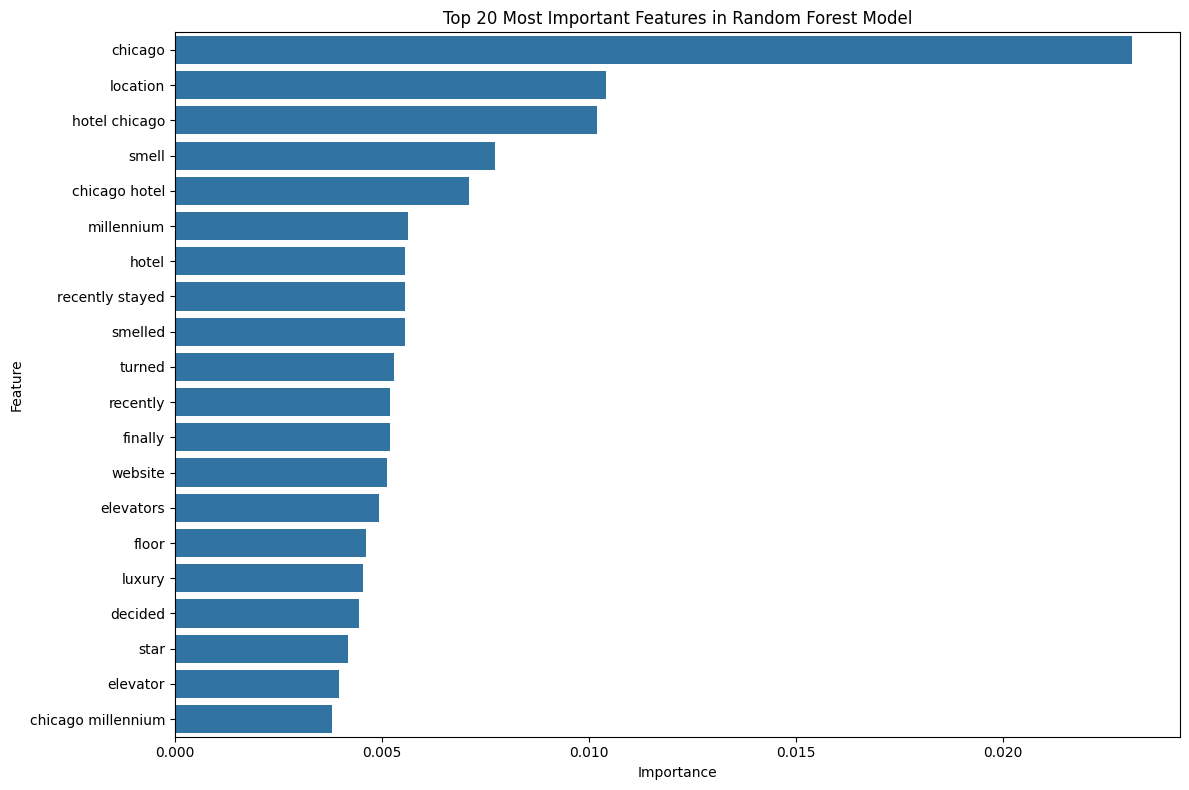

In [6]:
# Get feature importances from the best Random Forest model
feature_importances = best_model_rf.named_steps['classifier'].feature_importances_

# Get feature names from the vectorizer
feature_names = best_model_rf.named_steps['vectorizer'].get_feature_names_out()

# Create a dataframe of feature importances
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the dataframe by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=False)

# Display the top 20 most important features
print("Top 20 Most Important Features:")
print(importances_df.head(20))
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances_df.head(20))
plt.title('Top 20 Most Important Features in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
